# Advanced RAG Eval

The cookbook walks through the process of running eval(s) on advanced RAG. 

This can be very useful to determine the best RAG approach for your application.

In [ ]:
! pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)

In [ ]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

## Data Loading

Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US.

In [1]:
path = "/Users/rlm/Desktop/wildfire_stats/"

### Option 1: Load text

In [53]:
# Load
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader(path + "wildfire_stats.pdf")
pdf_pages = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits_pypdf = text_splitter.split_documents(pdf_pages)
all_splits_pypdf_texts = [d.page_content for d in all_splits_pypdf]

### Option 2: Load text, tables, images 



In [ ]:
from unstructured.partition.pdf import partition_pdf

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=path + "wildfire_stats.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Store

### Option 1: Embed, store text chunks

In [54]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
baseline = Chroma.from_texts(texts=all_splits_pypdf_texts,
                             collection_name="baseline",
                             embedding=OpenAIEmbeddings())
retriever_baseline=baseline.as_retriever()

### Option 2: Multi-vector retriever

#### Text Summary

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Text summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Apply to text 
text_summaries = texts # Skip text summarization

# Apply to tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

#### Image Summary

In [8]:
# Image summary chain
import os, base64, io
from io import BytesIO
from PIL import Image
from langchain.schema.messages import HumanMessage

def encode_image(image_path):
    ''' Getting the base64 string '''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8') 

def image_summarize(img_base64,prompt):
    ''' Image summary '''
    chat = ChatOpenAI(model="gpt-4-vision-preview",
                      max_tokens=1024)
    
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text":prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content

# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = "Describe the image in detail. Be specific about graphs, such as bar and line plots." 

# Apply to images
for img_file in sorted(os.listdir(path)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image,prompt))

### Option 2a: Multi-vector retriever w/ raw images

* Return images to LLM for answer synthesis

In [11]:
import uuid
from base64 import b64decode
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

def create_multi_vector_retriever(vectorstore, 
                                  text_summaries, 
                                  texts, 
                                  table_summaries, 
                                  tables, 
                                  image_summaries, 
                                  images):
    
    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    add_documents(retriever, text_summaries, texts)
    add_documents(retriever, table_summaries, tables)
    add_documents(retriever, image_summaries, images)

    return retriever

# The vectorstore to use to index the summaries
multi_vector_img = Chroma(collection_name="multi_vector_img", 
                     embedding_function=OpenAIEmbeddings())

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(multi_vector_img,
                              text_summaries,
                              texts,
                              table_summaries, 
                              tables, 
                              image_summaries, 
                              img_base64_list)

In [98]:
from IPython.display import display, HTML
def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    
    # Display the image by rendering the HTML
    display(HTML(image_html))


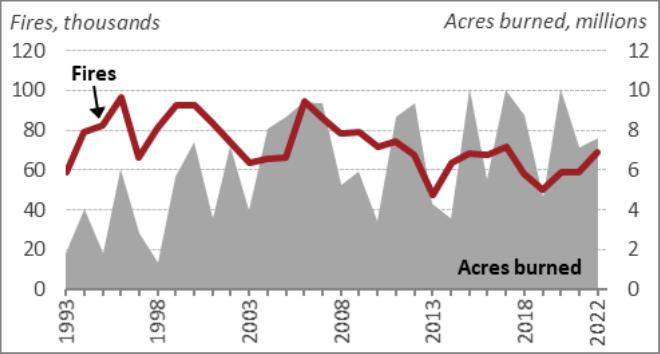

In [99]:
# Testing on retrieval 
query="How many acres burned due to wildfires in 2015 and how many files were there?"
adapter=" Use any related charts or figures, if present."
docs = retriever_multi_vector_img.get_relevant_documents(query+adapter)
plt_img_base64(docs[0])

### Option 2b: Multi-vector retriever w/ image summaries

* Return text summary of images to LLM for answer synthesis

In [15]:
# The vectorstore to use to index the summaries
multi_vector_text = Chroma(collection_name="multi_vector_text", 
                           embedding_function=OpenAIEmbeddings())

# Create retriever
retriever_multi_vector_img_summary = create_multi_vector_retriever(multi_vector_text,
                              text_summaries,
                              texts,
                              table_summaries, 
                              tables, 
                              image_summaries, 
                              image_summaries)

### Option 3: Multi-modal embeddings

In [19]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create chroma w/ multi-modal embeddings
multimodal_embd = Chroma(
    collection_name="multimodal_embd",
    embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs
image_uris = sorted([os.path.join(path, image_name) 
                     for image_name in os.listdir(path) 
                     if image_name.endswith('.jpg')])

# Add images and documents
multimodal_embd.add_images(uris=image_uris)
multimodal_embd.add_texts(texts=texts)
multimodal_embd.add_texts(texts=tables)

# Make retriever 
retriever_multimodal_embd = multimodal_embd.as_retriever()

## RAG

### Text Pipeline

In [56]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
rag_prompt_text = ChatPromptTemplate.from_template(template)

# Build 
def text_rag_chain(retriever):
    
    ''' RAG chain '''

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4")
    
    # RAG pipeline
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | rag_prompt_text
        | model
        | StrOutputParser()
    )

    return chain

### Multi-modal Pipeline

In [73]:
import re 
from langchain.schema import Document
from langchain.schema.runnable import RunnableLambda

def looks_like_base64(sb):
    """Check if the string looks like base64."""
    return re.match('^[A-Za-z0-9+/]+[=]{0,2}$', sb) is not None

def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data."""
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp"
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def split_image_text_types(docs):
    """Split base64-encoded images and texts."""
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

def img_prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            }
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "Answer the question based only on the provided context, which can include text, tables, and image(s). "
            "If an image is provided, analyze it carefully to help answer the question.\n"
            f"User-provided question / keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        )
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

def multi_modal_rag_chain(retriever):
    ''' Multi-modal RAG chain '''

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, 
                       model="gpt-4-vision-preview", 
                       max_tokens=1024)
    
    # RAG pipeline
    chain = (
        {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

### Build RAG Pipelines

In [75]:
# RAG chains
chain_baseline=text_rag_chain(retriever_baseline)
chain_mv_text=text_rag_chain(retriever_multi_vector_img_summary)

# Multi-modal RAG chains
chain_multimodal_mv_img=multi_modal_rag_chain(retriever_multi_vector_img)
chain_multimodal_embd=multi_modal_rag_chain(retriever_multimodal_embd)

## Eval set

In [77]:
# Read
import pandas as pd
eval_set = pd.read_csv(path+'wildfire_stats_eval.csv')
eval_set.head(3)

,Question,Answer,Source
0,How many acres burned due to wildfires in 2015...,10.13 million acres burned in 2015 due to 68.2...,Image
1,How many fires were there on department of int...,There were 7 thousand fires on DOI land in 2018.,Table
2,How many acres burned on department of interio...,There were 2.3 million acres burned on DOI lan...,Table


In [81]:
from langsmith import Client

# Dataset
client = Client()
dataset_name = f"Wildfire Eval {str(uuid.uuid4())}"
dataset = client.create_dataset(dataset_name=dataset_name)

# Populate dataset
for _, row in eval_set.iterrows():
    # Get Q, A
    q = row['Question']
    a = row['Answer']
    # Use the values in your function
    client.create_example(inputs={"question": q}, 
                          outputs={"answer": a}, 
                          dataset_id=dataset.id)

In [84]:
from langchain.smith import RunEvalConfig

eval_config = RunEvalConfig(
    evaluators=["qa"],
)

def run_eval(chain,run_name,dataset_name):
    _ = client.run_on_dataset(
        dataset_name=dataset_name,
        llm_or_chain_factory=lambda: (lambda x: x["question"]) | chain,
        evaluation=eval_config,
        project_name=run_name,
    )

for chain, run in zip([chain_baseline, chain_mv_text, chain_multimodal_mv_img, chain_multimodal_embd], 
                      ["baseline", "mv_text", "mv_img", "mm_embd"]):
    run_eval(chain, dataset_name+"-"+run, dataset_name)

View the evaluation results for project 'Wildfire Eval fe299812-f933-4167-a660-8436aea6c762-baseline' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/4d9e4562-a129-4ecc-b535-dd87139d927f?eval=true

View all tests for Dataset Wildfire Eval fe299812-f933-4167-a660-8436aea6c762 at:
https://smith.langchain.com/datasets/97bf1df8-d8ea-4331-b78f-05dae6cefc5e
[>                                                 ] 0/6

[------------------------------------------------->] 6/6View the evaluation results for project 'Wildfire Eval fe299812-f933-4167-a660-8436aea6c762-mv_text' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/55f42019-8ab2-46bc-a996-7a1730d04169?eval=true

View all tests for Dataset Wildfire Eval fe299812-f933-4167-a660-8436aea6c762 at:
https://smith.langchain.com/datasets/97bf1df8-d8ea-4331-b78f-05dae6cefc5e
[------------------------------------------------->] 6/6View the evaluation results for project 'Wildfire Eval fe299812-f933-4167-a660-8436aea6c762-mv_img' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/dacb1ab0-489e-43f6-90dc-e33ef9eb7518?eval=true

View all tests for Dataset Wildfire Eval fe299812-f933-4167-a660-8436aea6c762 at:
https://smith.langchain.com/datasets/97bf1df8-d8ea-4331-b78f-05dae6cefc5e
[------------------------------------------------->] 6/6View the evaluation results for project 'Wildfire Eval fe29

## Design Challenges
 
* Promote `image` retrieval over `text` documents.
* Query transformation to promote keywords for multi-modal embedding retrieval. 